# Dataset

## Sequence

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_sequences(dataset_dir, action_name, max_plot=None, max_len=100):

    sequence_dir, label_dir = os.path.join(dataset_dir, "sequence"), os.path.join(dataset_dir, "label")

    sequence_paths = []
    for fname in os.listdir(label_dir):
        if not fname.endswith('_label.csv'):
            continue
        label_path = os.path.join(label_dir, fname)
        label_df = pd.read_csv(label_path)
        if label_df.iloc[0]['action'] == action_name:
            seq_id = fname.replace('_label.csv', '')
            seq_path = os.path.join(sequence_dir, f'{seq_id}.csv')
            if os.path.exists(seq_path):
                sequence_paths.append(seq_path)
    
    if not sequence_paths:
        print(f"[Warning] No sequence found for action: {action_name}")
        return
    
    if max_plot is not None:
        sequence_paths = sequence_paths[:max_plot]
    
    plt.figure(figsize=(12, 6))
    for seq_path in sequence_paths:
        df = pd.read_csv(seq_path)
        df = df.iloc[:max_len]
        plt.plot(df['accel_x'].values, alpha=0.3, color='r', label='accel_x' if 'accel_x' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.plot(df['accel_y'].values, alpha=0.3, color='g', label='accel_y' if 'accel_y' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.plot(df['accel_z'].values, alpha=0.3, color='b', label='accel_z' if 'accel_z' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.title(f"All sequences for action: {action_name}")
    plt.xlabel("Frame index")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

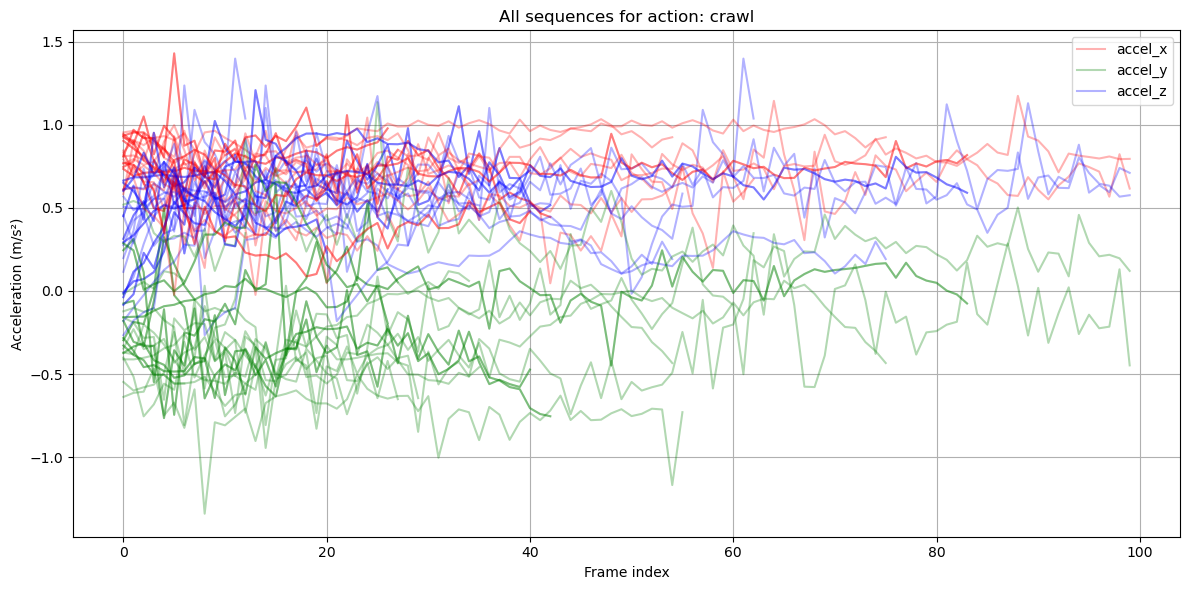

In [ ]:
# origin
plot_sequences(dataset_dir="./data_origin", 
               action_name="crawl",
               max_plot=None,
               max_len=100)


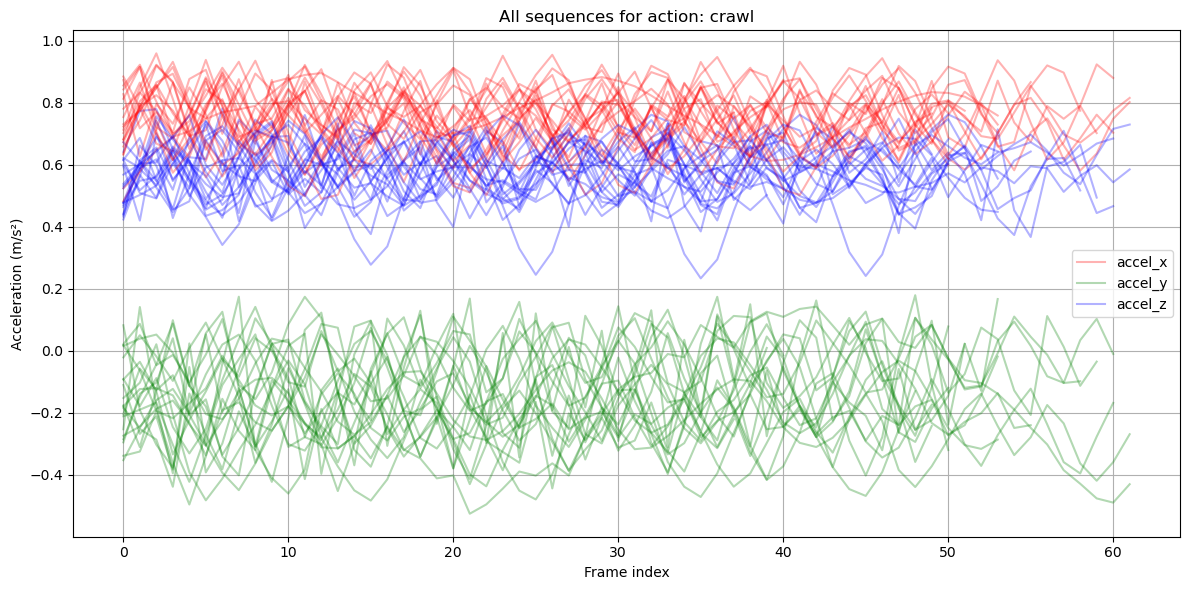

In [3]:
plot_sequences(dataset_dir="./data_aug/ChatGPT-o4-instructed_v2", 
               action_name="crawl",
               max_plot=None,
               max_len=100)

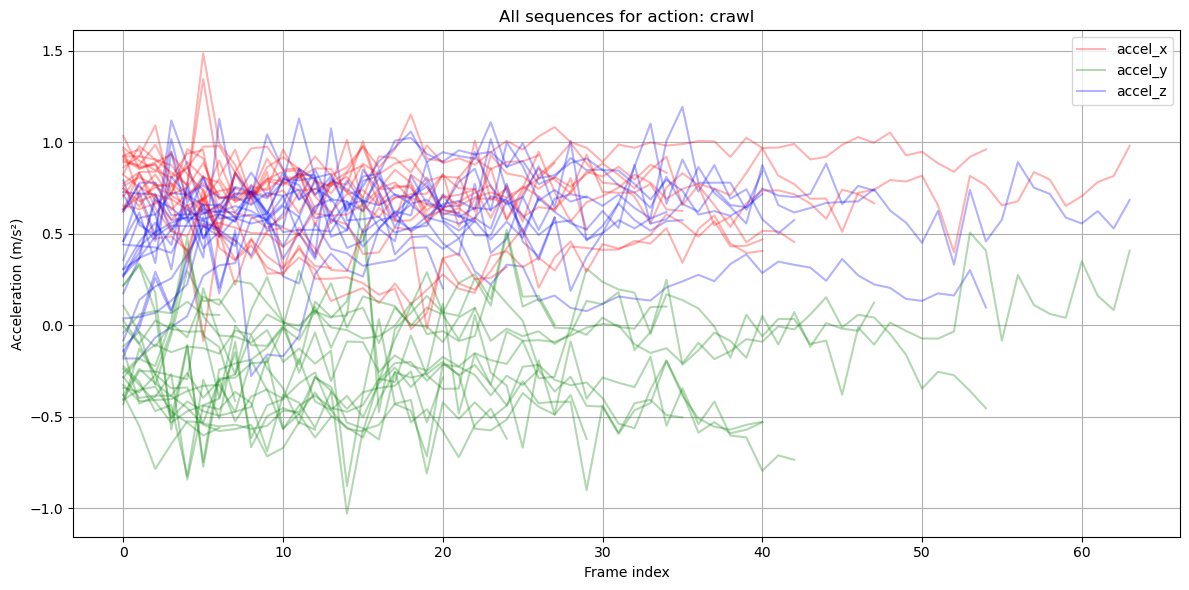

In [4]:
plot_sequences(dataset_dir="./data_aug/GN", 
               action_name="crawl",
               max_plot=None,
               max_len=100)

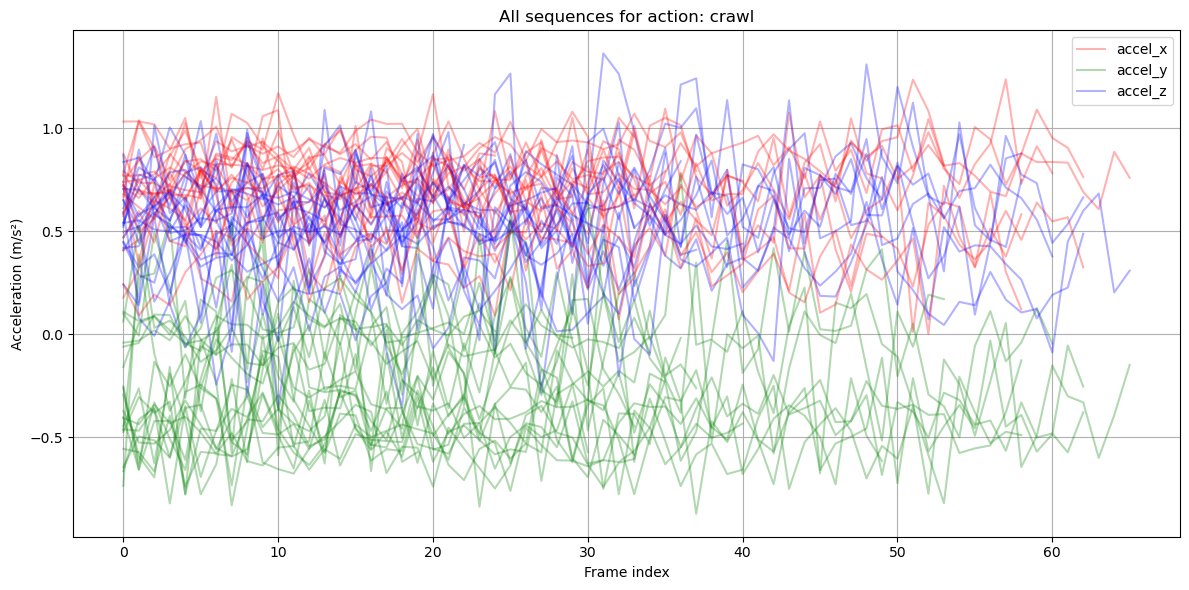

In [5]:
plot_sequences(dataset_dir="./data_aug/GS", 
               action_name="crawl",
               max_plot=None,
               max_len=100)

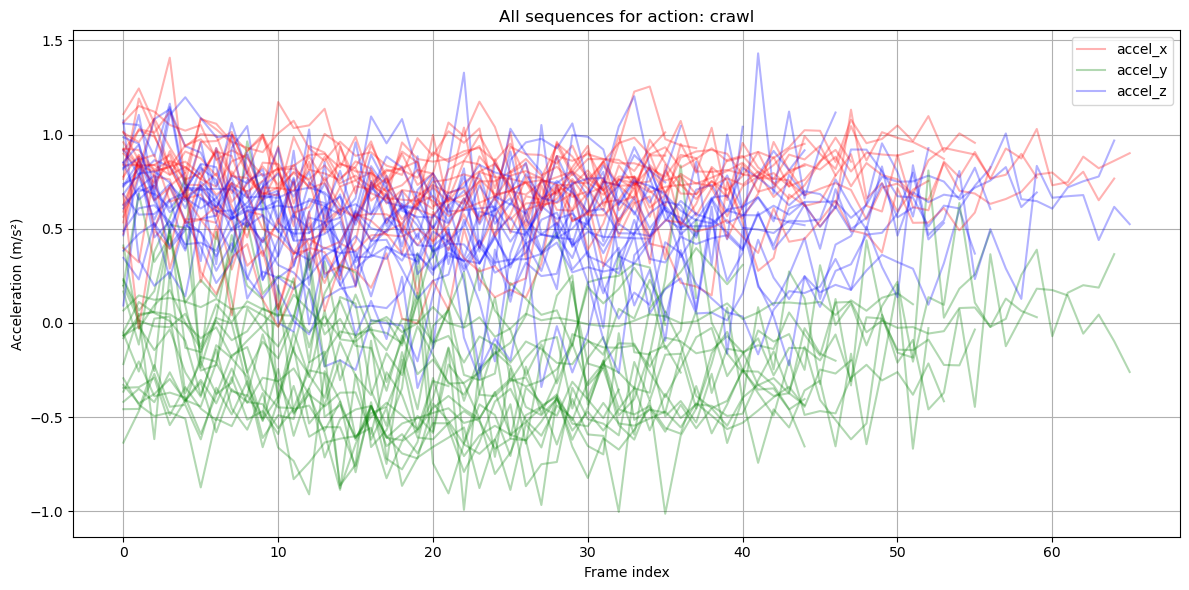

In [6]:
plot_sequences(dataset_dir="./data_aug/CS", 
               action_name="crawl",
               max_plot=None,
               max_len=100)

## PCA

In [7]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

def extract_features(dataset_dir, label2idx, max_len=100):

    sequence_dir, label_dir = os.path.join(dataset_dir, "sequence"), os.path.join(dataset_dir, "label")
    features = []
    labels = []

    for fname in tqdm(os.listdir(label_dir)):
        if not fname.endswith('_label.csv'):
            continue

        label_path = os.path.join(label_dir, fname)
        seq_id = fname.replace('_label.csv', '')
        seq_path = os.path.join(sequence_dir, f"{seq_id}.csv")

        if not os.path.exists(seq_path):
            continue

        df = pd.read_csv(seq_path)
        df = df[["accel_x", "accel_y", "accel_z"]].values
        if len(df) < 10:
            continue

        if len(df) > max_len:
            df = df[:max_len]
        else:
            pad_len = max_len - len(df)
            df = np.pad(df, ((0, pad_len), (0, 0)), mode='constant')

        label_df = pd.read_csv(label_path)
        action = label_df.iloc[0]["action"]
        label_idx = label2idx.get(action, None)
        if label_idx is None:
            continue

        features.append(df.flatten())
        labels.append(label_idx)

    return np.array(features), np.array(labels)

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_2d(features, labels, method='pca', label_names=None, title=None):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    reduced = reducer.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        idx = labels == label
        name = label_names[label] if label_names else str(label)
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=name, alpha=0.6, s=20)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title or f"2D projection using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

In [9]:
label2idx = {
    'crawl': 0, 'walk': 1,
    'sit-floor': 2, 'sit-high-chair': 3, 'sit-low-chair': 4, 'stand': 5, 
    'hold-horizontal': 6, 'hold-vertical': 7, 'piggyback': 8, 
    'baby-food': 9, 'bottle': 10, 'breast': 11, 
    'face-down': 12, 'face-side': 13, 'face-up':14, 'roll-over': 15
}

idx2label = {v: k for k, v in label2idx.items()}

100%|██████████| 550/550 [00:01<00:00, 334.17it/s]


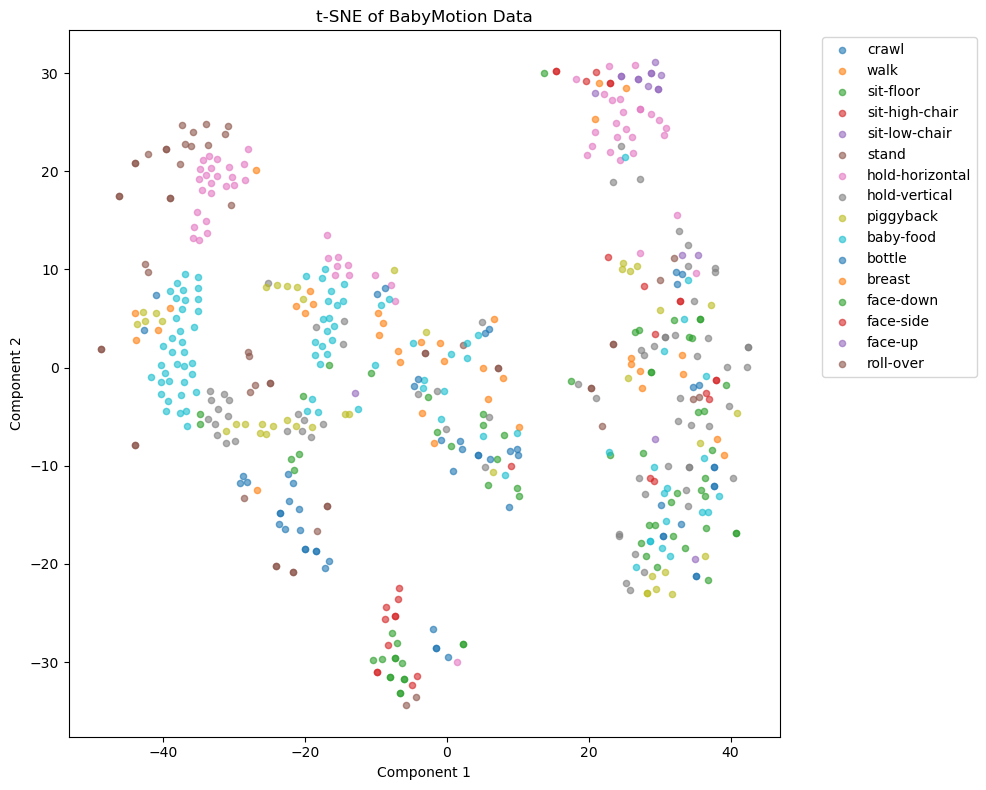

In [13]:
features, labels = extract_features(
    dataset_dir="./data_origin",
    label2idx=label2idx,
    max_len=100
)

plot_2d(features, labels, method='tsne', label_names=idx2label, title='t-SNE of BabyMotion Data')

100%|██████████| 300/300 [00:00<00:00, 326.01it/s]


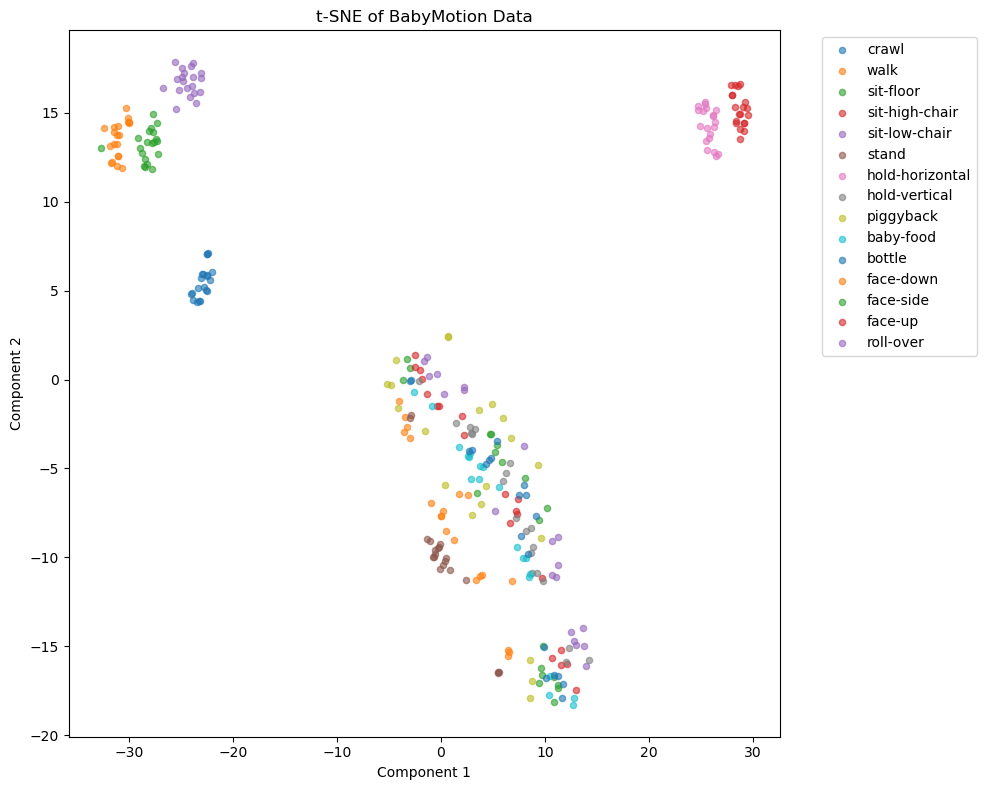

In [14]:
features, labels = extract_features(
    dataset_dir="./data_aug/ChatGPT-o4-instructed_v2",
    label2idx=label2idx,
    max_len=100
)

plot_2d(features, labels, method='tsne', label_names=idx2label, title='t-SNE of BabyMotion Data')

100%|██████████| 300/300 [00:00<00:00, 334.51it/s]


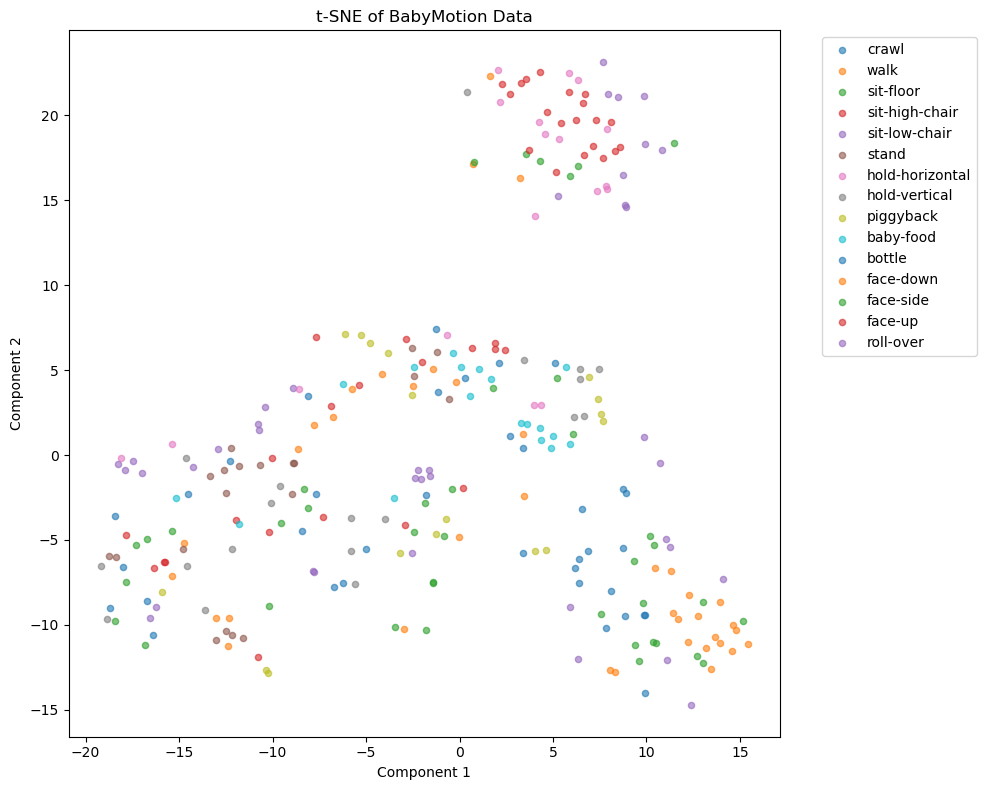

In [15]:
features, labels = extract_features(
    dataset_dir="./data_aug/GN",
    label2idx=label2idx,
    max_len=100
)

plot_2d(features, labels, method='tsne', label_names=idx2label, title='t-SNE of BabyMotion Data')

100%|██████████| 300/300 [00:00<00:00, 336.83it/s]


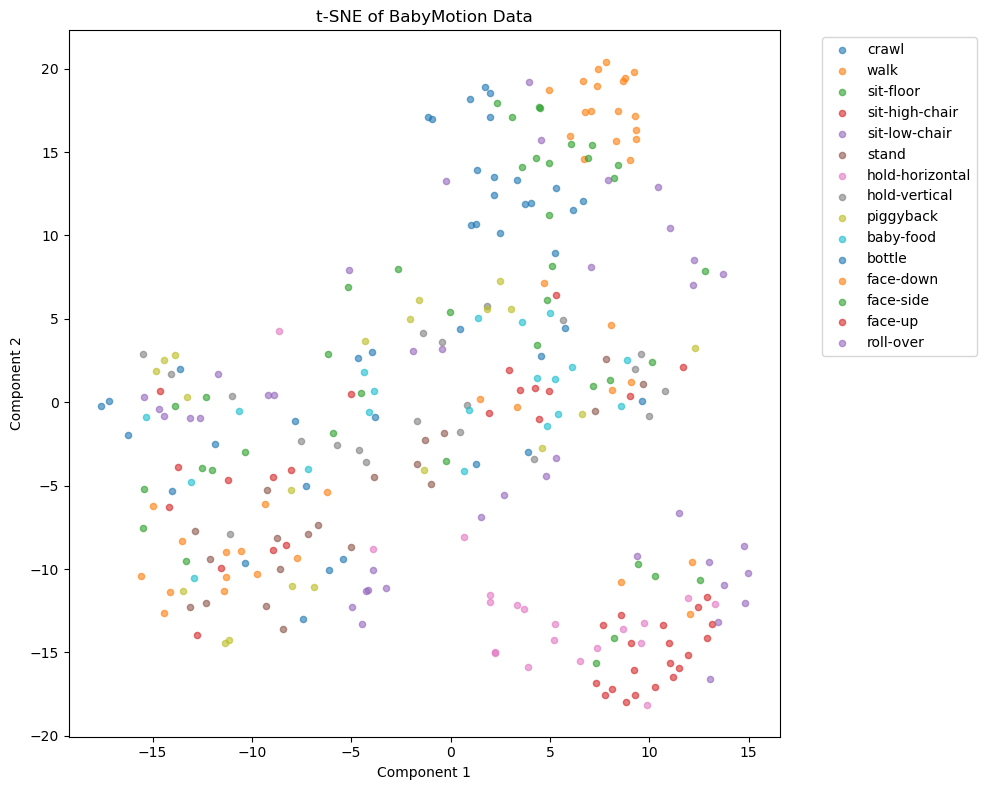

In [16]:
features, labels = extract_features(
    dataset_dir="./data_aug/GS",
    label2idx=label2idx,
    max_len=100
)

plot_2d(features, labels, method='tsne', label_names=idx2label, title='t-SNE of BabyMotion Data')

100%|██████████| 300/300 [00:00<00:00, 328.17it/s]


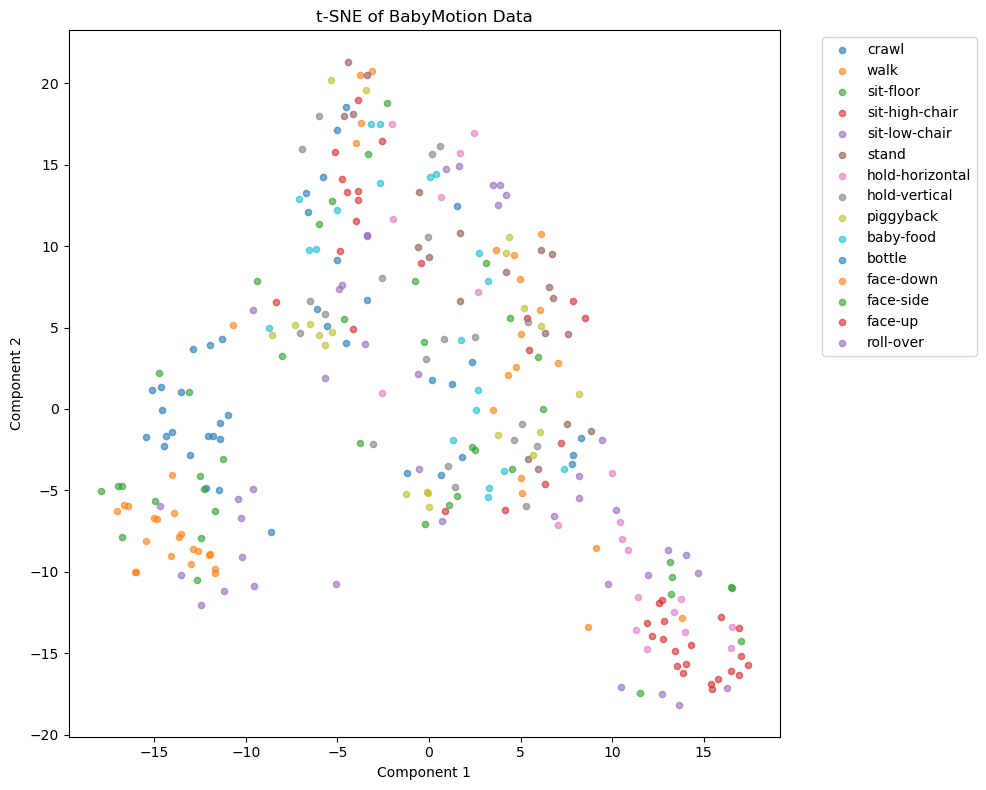

In [17]:
features, labels = extract_features(
    dataset_dir="./data_aug/CS",
    label2idx=label2idx,
    max_len=100
)

plot_2d(features, labels, method='tsne', label_names=idx2label, title='t-SNE of BabyMotion Data')

## DTW

In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dtw import dtw
from numpy.linalg import norm
from tqdm import tqdm

def load_action_sequences(data_dir, max_samples_per_action=20, max_len=100):
    action_to_seqs = {}
    label_dir = os.path.join(data_dir, 'label')
    seq_dir = os.path.join(data_dir, 'sequence')

    for label_file in os.listdir(label_dir):
        if not label_file.endswith('_label.csv'):
            continue
        label_path = os.path.join(label_dir, label_file)
        seq_id = label_file.replace('_label.csv', '')
        seq_path = os.path.join(seq_dir, f'{seq_id}.csv')
        if not os.path.exists(seq_path):
            continue

        try:
            label_df = pd.read_csv(label_path)
            action = label_df.iloc[0]['action']
            df = pd.read_csv(seq_path)[['accel_x', 'accel_y', 'accel_z']].values
            if len(df) > max_len:
                df = df[:max_len]
            if action not in action_to_seqs:
                action_to_seqs[action] = []
            if len(action_to_seqs[action]) < max_samples_per_action:
                action_to_seqs[action].append(df)
        except:
            continue

    return action_to_seqs

def compute_dtw_matrix(original_seqs, generated_seqs):
    dtw_matrix = np.zeros((len(original_seqs), len(generated_seqs)))
    for i, o_seq in enumerate(original_seqs):
        for j, g_seq in enumerate(generated_seqs):
            distance = dtw(o_seq, g_seq, dist_method=lambda x, y: norm(x - y)).distance
            dtw_matrix[i, j] = distance
    return dtw_matrix

def plot_dtw_heatmap(original_dir, generated_dir, action='crawl', max_samples=20, max_len=100):
    print(f"正在处理动作: {action}")
    origin_dict = load_action_sequences(original_dir, max_samples, max_len)
    gen_dict = load_action_sequences(generated_dir, max_samples, max_len)

    if action not in origin_dict or action not in gen_dict:
        print(f"动作 {action} 不在数据集中")
        return

    origin_seqs = origin_dict[action]
    gen_seqs = gen_dict[action]

    dtw_matrix = compute_dtw_matrix(origin_seqs, gen_seqs)

    plt.figure(figsize=(10, 8))
    sns.heatmap(dtw_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
    plt.title(f"DTW Heatmap: Original vs Generated ({action})")
    plt.xlabel("Generated Sequences")
    plt.ylabel("Original Sequences")
    plt.tight_layout()
    plt.show()

正在处理动作: crawl


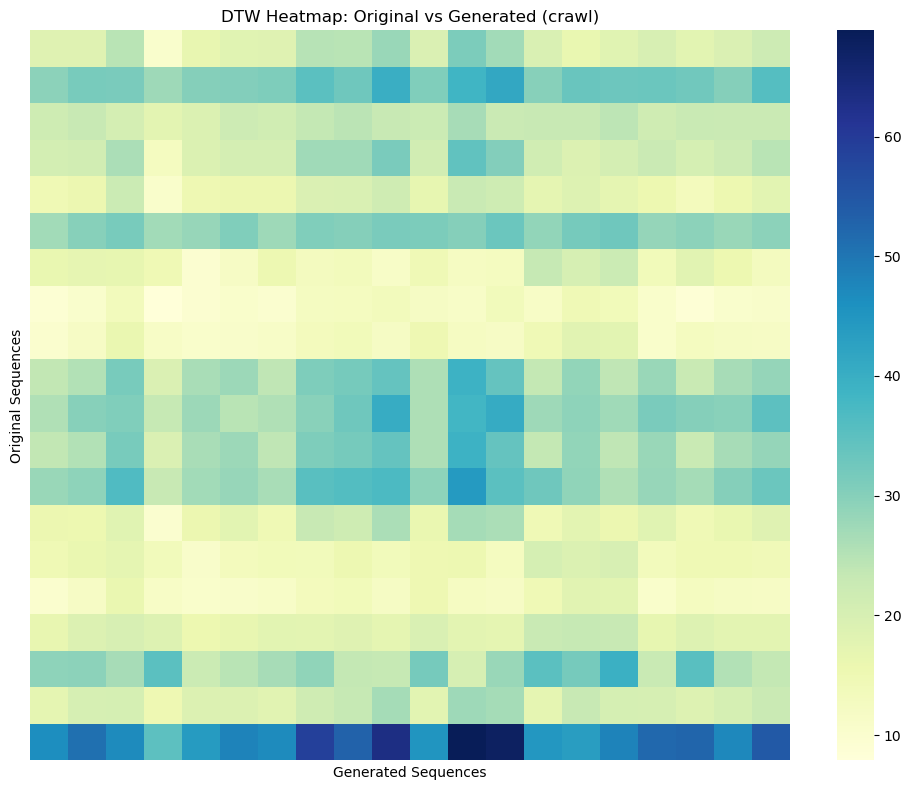

In [25]:
original_dir = './data_origin'
generated_dir = './data_aug/ChatGPT-o4-instructed_v2'
plot_dtw_heatmap(original_dir, generated_dir, action='crawl')

正在处理动作: crawl


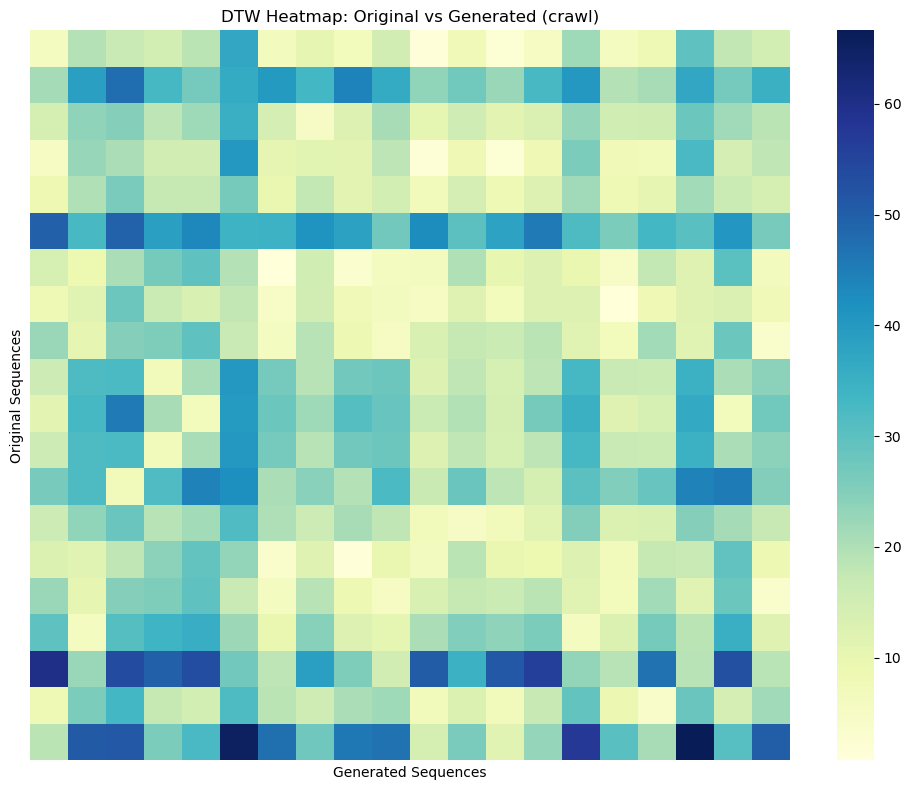

In [26]:
original_dir = './data_origin'
generated_dir = './data_aug/GN'
plot_dtw_heatmap(original_dir, generated_dir, action='crawl')

正在处理动作: crawl


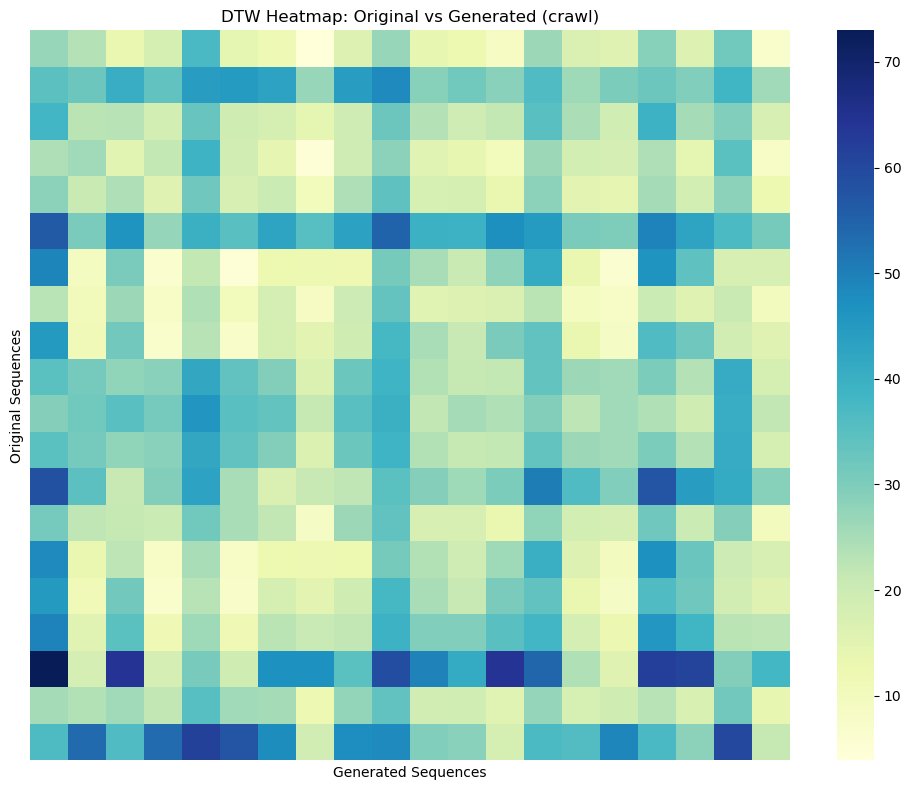

In [28]:
original_dir = './data_origin'
generated_dir = './data_aug/GS'
plot_dtw_heatmap(original_dir, generated_dir, action='crawl')

正在处理动作: crawl


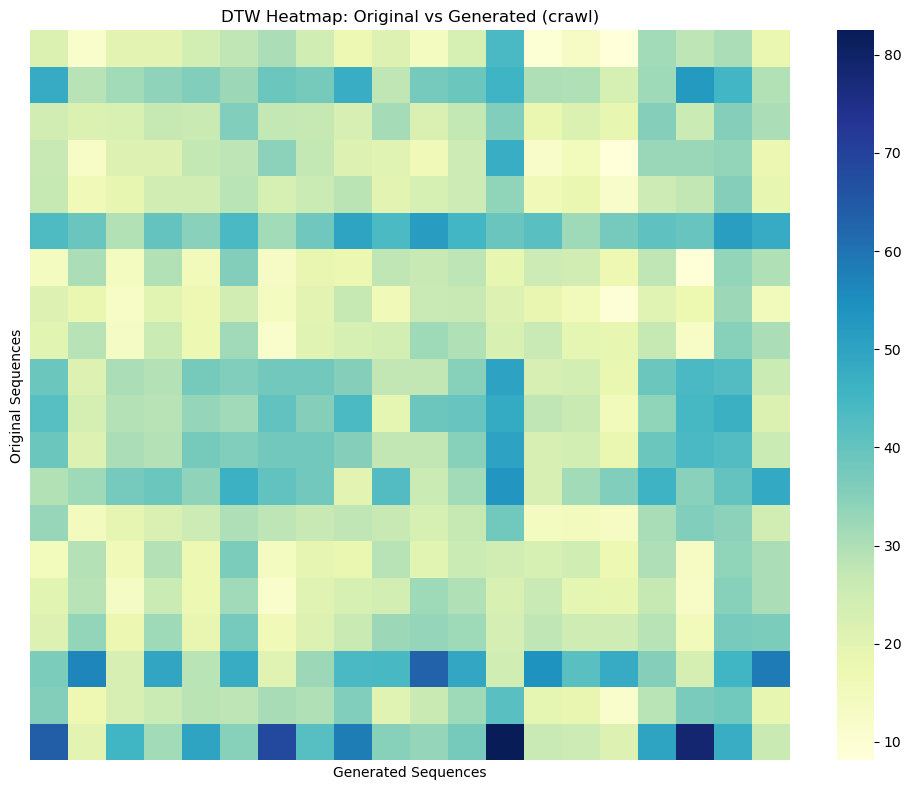

In [29]:
original_dir = './data_origin'
generated_dir = './data_aug/CS'
plot_dtw_heatmap(original_dir, generated_dir, action='crawl')

# GAN trainning process

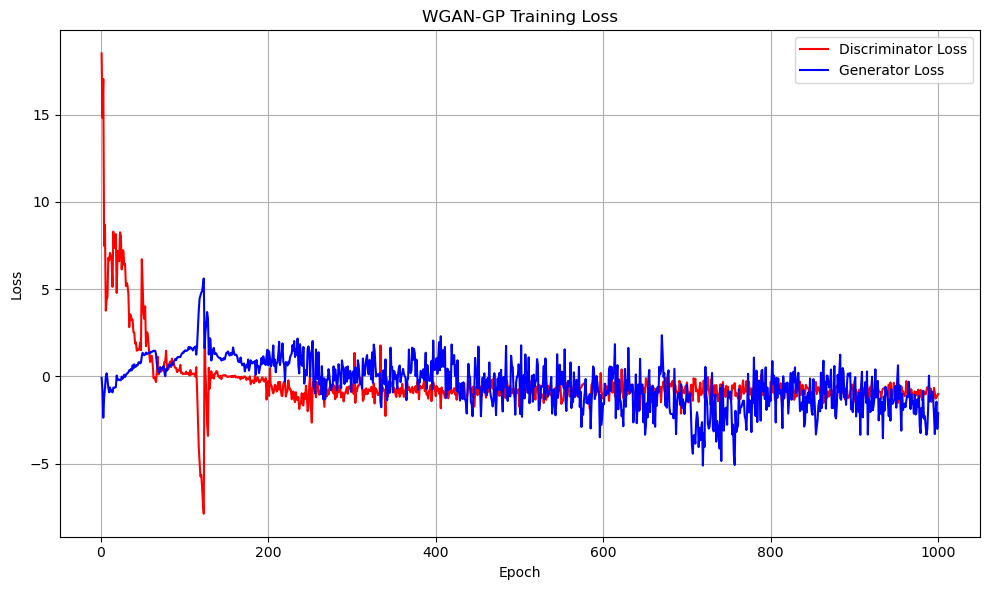

In [1]:
from utils.visualize import visualize_gan_losses

visualize_gan_losses("./logs/aug_GAN/20250617_214011/train.log")

# Classification Task